# Introduction and Questions

This project aims to analyze the SOCT survey responses received at MSU and relate these with publically-available information on the grade distributions by course. For those who are unfamiliar, SOCT stands for "Student Opinion of Courses and Teaching." These surveys are administered by MSU for the purpose of identifying areas for improvement and for providing information to students as they are enrolling in classes. The surveys consist of six Likert-scale questions:
1. Overall was the instructor effective?
2. Overall was the course worthwhile?
3. Was the instructor available to help students outside of class?
4. Was the workload reasonable for the mastery of the course material?
5. Was the course well organized?
6. Was I interested in taking this course?

This data is obtained through the https://soct.msu.edu/ webpage. Note that valid credentials are required in order to view the responses. The data from the surveys are only provided in summary form; the percent of respondents choosing each answer is provided. Furthermore, the number of responses must be greater than a certain number in order to display the results (otherwise, it may be possible for the respondents to be identified). At the time of this project, the SOCT website displayed data for the Spring 2020 semester.

The website https://msugrades.com/ contains grade data for MSU courses. This website is not affiliated with MSU; rather, the data was obtained through Freedom of Information Act requests. Courses where there were 10 or fewer students enrolled are not included in this data. For this project, the Spring 2020 grades were used.

The questions this project aims to answer are:
* Is there a correlation between the responses students provide on SOCT survey questions and the grades they receive?
* How do the SOCT survey responses vary between subjects? Do certain subjects receive more favorable responses, on average?
* How do the SOCT survey responses and average grades vary between course levels?

For the first question, note that the purpose of the models fitted is not to create a means of predicting student grades from their SOCT responses. Rather, they are solely meant to establish whether there is a correlation or relationship. Therefore, the R-squared values are of less importance than the p-values of the coefficient.

The reason why SOCT questions were chosen as the independent variable are two-fold. First, it enables multiple regression to be performed (since multiple predictors are allowed but multiple dependent variables are not). Secondly, the survey responses are likely closer to the cause of the grade being what it is. For example, if a student is struggling to understand the content of a course and is unable to get help, this will reflect itself in the third survey question and will ultimately lead to a lower grade (rather than it reflecting itself in a lower grade which results in the response to the third question). Of course, we do not have the tools to prove causation, since the "cause" is likely a variable that is neither SOCT responses nor average grade (and is rather a separate variable that manifests itself in both). Nevertheless, it is likely that this "variable" is closely associated with the responses the students provide on the SOCT survey.

For the last two questions, the method of analysis will be through data visualization, rather than rigorous statistical inference.

# Import Statements

Below are the packages and functions used herein. To successfully run this notebook, it may be required to install some of these packages. Also note that a slightly modified copy of the OLSplots package by Jason Sadowski is included in the GitHub repository; it should be ensured that this version is used, rather than the original.

In [1]:
# Imports for data representation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for web scraper
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException        

# Imports for utilities and display functions
from time import sleep
from os import getcwd
from warnings import warn
from ipywidgets.widgets import interact, IntSlider
from IPython.display import display, Markdown

# Imports for regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Module from Jason Sadowski at https://github.com/j-sadowski/FromRtoPython/blob/master/OLSplots.py
# Used for diagnostic plots of linear regression models
from OLSplots import allplots 

# Module for making ridge plots
from joypy import joyplot

# Transformations for normalizing skewed data
from scipy.special import inv_boxcox
from scipy.stats import boxcox

# Data Gathering

## SOCT Scraping

The SOCT data is not available in a downloadable format. Thus, in order to obtain it, we use web scraping. Specifically, the Selenium package is used along with a Chrome webdriver. A copy of the webdriver is included in the GitHub repository, although depending on the version of Chrome being used, a different one may need to be downloaded. The downloads are available at https://chromedriver.chromium.org/getting-started.

A class called `Data` is defined to hold the scraped data for each course. The purpose of this is less about object-oriented programming, and more as a means of grouping related data in an unambiguous way. Later in the project, a list of these objects is iterated over, aggregations are performed, and the data is stored in a DataFrame.

The webscraping itself takes a few hours to complete. It stores the results as `Data` objects to a global list called `searches`. The scraper may occasionally crash for unclear reasons (or it may not). In the case that it does, it is recommended to print the subject of each Data object currently scraped, and delete all entries with the same subject as that of the last-scraped course. Restart the scraper in a new cell, and log in. Call `get_subjects` and find the index of the subject that was just removed. Terminate the scraper. Then, change the starting index of the loop in `subjects_iterate` to that index, comment out the line initializing `searches`, and begin the webscraper again.

This effectively will pick up where you left off. However, in order to make iteration easier, and to ensure none of the data was corrupted, all entries of the most recently scraped subject are removed and reread.

Were this code to be included in a package, a more robust function would be coded. However, since it is so time-consuming to scrape the data, it is assumed that the reader will likely not re-run the code, and will instead use the data saved in the `output` folder in the GitHub. For the purpose of demonstration, however, the code below can be run (with valid credentials) to scrape the first three subjects. If all subjects are to be scraped, then `True` should be changed to `False` in the call of `subjects_iterate`.

In [2]:
class Data:
    '''Class used to hold the data for each course scraped from the SOCT surveys. The default constructor is used.
    To fill a Data object with the information currently open on the web scraper, call read_page. To save a list of
    data objects, use save_data. To reload this data, use load_data.
    
    Attributes
    ----------
    subject: str
        The subject code for the course.
        
    subject_desc: str
        The subject in full-text.
        
    course: str
        The course number.
        
    course_desc: str
        The name of the course.
        
    prof: str
        The name of the professor.
        
    semesters: str
        The semester to which the SOCT data pertains.
        
    table: DataFrame
        The SOCT survey responses. The index is given by Data.index. The columns are given by Data.columns. The 
        entries are not all numerical.
    '''
    
    index = ["strongly_agree", "agree", "neutral", "disagree", "strongly_disagree", "na", "responses"]
    columns = ["effective_prof", "worthwhile_course", "help_available", "workload", "course_organization", "course_interest"]
    
    def _repr_html_(self):
        '''Specify the output of the object by Jupyter.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        output: str
            The HTML string representing the object. If data is missing, then "Incomplete Data" is returned.
        '''
        
        try:
            output = ""
            output += "<p>"+self.subject+" " + self.course+"</p>"
            output += "<p>"+self.subject_desc+"</p>"
            output += "<p>"+self.course_desc+"</p>"
            output += "<p>"+self.prof+"</p>"
            output += "<p>"+self.semesters+"</p>"
            output += self.table._repr_html_() # Display the table using the html formatting of a DataFrame
            return output
        except: # In case the attributes of the data object were not assigned
            return "Incomplete Data"
    
    def read_page(self):
        '''Store the data on the current page of the web driver to the Data object.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        
        info_prof, info_course, info_semesters = soct_driver.find_elements(By.XPATH, "//dd")
        self.prof = info_prof.text
        info_course, self.course_desc = info_course.text.split(" - ", 1)
        self.subject, self.course, self.subject_desc = info_course.split(" ", 2)
        self.semesters = info_semesters.text
        
        table = []
        for row in soct_driver.find_elements(By.XPATH, "//table[@id='student-responses']/tbody/tr"):
            row_data = []
            for val in row.find_elements(By.XPATH, "./td[@class='bar-cell text-center']/table/tbody/tr/td[1]/p"):
                row_data.append(val.text)
            num_responses = row.find_element(By.XPATH, "./td[not(@class)]/p[1]").text.split(" = ")[1]
            row_data.append(num_responses)
            table.append(row_data)
        self.table = pd.DataFrame(table, index=Data.columns, columns=Data.index).T
        
    def save_data(data_list, folder):
        '''Save a list of data objects to csv and txt files. Note that one csv file is used to hold the table of
        each data object. Text files hold the other attributes.
        
        Parameters
        ------
        data_list: list
            List of Data objects to save.
            
        folder: str
            The folder name to which the results are saved. Note that it must already be created.
            
        Returns
        -------
        None
        '''
        
        with open(folder+"/prof.txt", "w") as prof:
            for value in [data.prof for data in data_list]:
                prof.write(value+"\n")
        
        with open(folder+"/course_desc.txt", "w") as course_desc:
            for value in [data.course_desc for data in data_list]:
                course_desc.write(value+"\n")
        
        with open(folder+"/subject.txt", "w") as subject:
            for value in [data.subject for data in data_list]:
                subject.write(value+"\n")
        
        with open(folder+"/course.txt", "w") as course:
            for value in [data.course for data in data_list]:
                course.write(value+"\n")
        
        with open(folder+"/subject_desc.txt", "w") as subject_desc:
            for value in [data.subject_desc for data in data_list]:
                subject_desc.write(value+"\n")
        
        with open(folder+"/semesters.txt", "w") as semesters:
            for value in [data.semesters for data in data_list]:
                semesters.write(value+"\n")
        
        for i, data in enumerate(data_list):
            data.table.to_csv(folder+"/dataframe"+str(i)+".csv")
            
    def load_data(folder):
        '''Reload a list of data objects. The folder must contain all of the files created by a previous run of 
        save_data.
        
        Parameters
        ----------
        folder: str
            The folder name containing the files to load.
            
        Returns
        -------
        output: list
            The list of data objects.
        '''
        
        with open(folder+"/prof.txt", "r") as prof: # Read the professors
            prof_list = prof.readlines()
            prof_list = [line.rstrip() for line in prof_list]
        
        with open(folder+"/course_desc.txt", "r") as course_desc: # Read the course descriptions
            course_desc_list = course_desc.readlines()
            course_desc_list = [line.rstrip() for line in course_desc_list]
        
        with open(folder+"/subject.txt", "r") as subject: # Read the subjects
            subject_list = subject.readlines()
            subject_list = [line.rstrip() for line in subject_list]
        
        with open(folder+"/course.txt", "r") as course: # Read the course numbers
            course_list = course.readlines()
            course_list = [line.rstrip() for line in course_list]
        
        with open(folder+"/subject_desc.txt", "r") as subject_desc: # Read the subject descriptions
            subject_desc_list = subject_desc.readlines()
            subject_desc_list = [line.rstrip() for line in subject_desc_list]
        
        with open(folder+"/semesters.txt", "r") as semesters: # Read the semesters
            semesters_list = semesters.readlines()
            semesters_list = [line.rstrip() for line in semesters_list]
        
        # Check to ensure that the lists of attributes are the same length
        if not len(prof_list) == len(course_desc_list) == len(subject_list) == len(course_list) == len(subject_desc_list) == len(semesters_list):
            raise RuntimeError("Files contain data of different lengths")
        
        # Create a list of dataframes representing the SOCT survey results
        table_list = [pd.read_csv(folder+"/dataframe"+str(i)+".csv", index_col=0) for i in range(len(prof_list))]
        
        # Create Data objects, initialize their attributes, and store them to output
        output = []
        for prof, course_desc, subject, course, subject_desc, semesters, table in zip(prof_list, course_desc_list, subject_list, course_list, subject_desc_list, semesters_list, table_list):
            data_obj = Data()
            data_obj.prof = prof
            data_obj.course_desc = course_desc
            data_obj.subject = subject
            data_obj.course = course
            data_obj.subject_desc = subject_desc
            data_obj.semesters = semesters
            data_obj.table = table
            output.append(data_obj)
            
        return output

In [3]:
# Start the web scraper
soct_driver = webdriver.Chrome(service=Service(f'{getcwd()}/chromedriver.exe'))
soct_driver.get("https://soct.msu.edu/")

In [4]:
def log_in(username, password):
    '''Log in to the SOCT survey website.
    
    Parameters
    ----------
    username: str
        A username for the website.
        
    password: str
        The corresponding password for the website.
    '''
    
    soct_driver.find_element(By.ID, "msu-id").send_keys(username)
    soct_driver.find_element(By.ID, "password").send_keys(password)
    soct_driver.find_element(By.ID, "login-submit").click()
        
def back():
    '''Return to the previous page in the web scraper.'''
    
    soct_driver.execute_script("window.history.go(-1)")

def get_subjects():
    '''Get access to the subject dropdown.
    
    Returns
    -------
    output: Select
        A Select object with the dropdown information.
    '''
    
    return Select(soct_driver.find_element(By.ID, "Select_SubjectCode"))
    
def get_courses():
    '''Get access to the course number dropdown.
    
    Returns
    -------
    output: Select
        A Select object with the dropdown information.
    '''
    
    return Select(soct_driver.find_element(By.ID, "Select_CourseNumber"))
    
def get_profs():
    '''Get access to the professor dropdown.
    
    Returns
    -------
    output: Select
        A Select object with the dropdown information.
    '''
    
    return Select(soct_driver.find_element(By.ID, "Select_Instructor"))
    
def check_received():
    '''Check whether SOCT forms were received for the search.
    
    Returns
    -------
    output: bool
        True if SOCT forms were received. False otherwise.
    '''
    
    return not len(soct_driver.find_elements(By.XPATH, "//*[contains(text(), 'No SOCT forms were received')]"))

def check_sufficient():
    '''Check whether a sufficient number of SOCT forms were received.
    
    Returns
    -------
    output: bool
        True if a sufficient number of SOCT forms were received. False otherwise.
    '''
    
    return not len(soct_driver.find_elements(By.XPATH, "//h1[contains(text(), 'Insufficient data')]"))

def subjects_iterate(sample = False):
    '''Iterate over the subjects dropdown menu. This function calls courses_iterate for each search performed.
    
    Parameters
    ----------
    sample: bool
        If True, only scrape the first three subject codes (for demonstration purposes). Defaults to False.
    '''
    
    subjects = get_subjects()
    for subj_idx in range(0, 3 if sample else len(subjects.options)):
        subjects.select_by_index(subj_idx)
        soct_driver.find_element(By.ID, "submit_subjectcode_1").click()
        courses_iterate()
        back()
        subjects = get_subjects()
        
def courses_iterate():
    '''Iterate over the courses dropdown menu. This function calls profs_iterate for each successful search 
    performed.'''
    
    courses = get_courses()
    for course_idx in range(len(courses.options)):
        courses.select_by_index(course_idx)
        soct_driver.find_element(By.ID, "submit_coursenumber_1").click()
        if check_received():
            profs_iterate()
        back()
        courses = get_courses()

def profs_iterate():
    '''Iterate over the professor dropdown menu. This function creates a new data object for each successful search,
    and appends it to a list called searches which must be defined beforehand in the global scope.'''
    
    profs = get_profs()
    for prof_idx in range(len(profs.options)):
        profs.select_by_index(prof_idx)
        soct_driver.find_element(By.ID, "submit_instructor_1").click()
        if check_sufficient():
            data_obj = Data()
            data_obj.read_page()
            searches.append(data_obj)
        back()
        profs = get_profs() 

In [5]:
log_in(<username>, <password>) # INSERT USERNAME AND PASSWORD HERE
searches = [] # Initialize searches list
subjects_iterate(True) # Begin a sample scraping process, storing all Data objects to the searches list

Data.save_data(searches, "sample_output") # Save the data to the folder sample_output

In [6]:
searches = Data.load_data("output") # Load the full data from the folder output

In [7]:
def display_searches(searches):
    '''Display the Data objects contained in a list using an interactive widget.
    
    Parameters
    ----------
    searches: list
        List of data objects to display.
    '''
    
    @interact(Index = IntSlider(min=0, max=len(searches)-1, step=1, value=0))
    def inner(Index):
        return searches[Index]
    
display_searches(searches)

interactive(children=(IntSlider(value=0, description='Index', max=2519), Output()), _dom_classes=('widget-inte…

## SOCT Data-Cleaning

Now that the SOCT data is scraped, it is necessary to change it to a useable format. The number of responses is not needed, so that will be dropped. We then notice that the datatype of the columns will need to be converted to floats by stripping the percent signs (and then dividing by 100). The percent of responses that are not applicable is not relevant, so it will be dropped as well. However, after doing this, the column sums will no longer equal 1. To fix this, the data in each column are divided by the sum of the column. If all the responses were not applicable, then this will introduce NA values into the dataset, which can then be dropped.

At this point, when making the models, it would be possible to perform multivariable regression using the proportion for each of the five repsonses (strongly disagree, disagree, neutral, agree, and strongly agree). However, this has several potential issues:
* The greater number of predictors may result in overfitting, since the dataset is not that large
* This may cause multicollinearity, since each of these proportions is strongly related to the others. In fact, since the proportions will sum to 1, at least one of the responses would have to be dropped; otherwise, any one of them could be expressed in terms of the others

Instead, we will aggregate the five proportions using a measure of central tendency. Specifically, let each Likert option be represented by equally spaced numbers between 0 for "strongly disagree" and 1 for "strongly agree." Then, a weighted average is performed, using the proportions as weights. In a strict statistical sense, this practice is controversial, since the distances between the Likert options are not necessarily equal. A better measure of central tendency would be the median. However, as is seen in many of the above displays, the vast majority of students respond with "agree" or "strongly agree," so using the median would not reflect the responses that are "disagree" or "strongly disagree." This would result in nearly all courses having the same data, thereby preventing any relationships from being found. Therefore, we elect to use the mean, noting its possible limitations.

In [8]:
def weighted_average(column):
    '''Get the weighted average of a Likert-scale column. Uses 1 to represent strongly agree and 0 to represent
    strongly disagree, with the other options spaced evenly between these.
    
    Parameters
    ----------
    column: Series
        The column for which the weighted average is calculated.
    
    Returns
    -------
    output: float
        The weighted average of the column.
    '''
    
    weights = [1, .75, .5, .25, 0]
    column = column[:5].str.strip("%").astype(float) # First remove parentheses and convert to decimal
    column = column/sum(column)*weights # Then normalize and multiply by weights
    return sum(column)

In [9]:
data_list = []

for data in searches:
    # Initialize a dictionary of the relevant attributes to save
    values = {"subject": data.subject,
              "subject_desc": data.subject_desc,
              "course": data.course,
              "prof": data.prof}
    
    # Add the weighted averages of the SOCT columns to values
    for var in data.columns:
        values[var] = weighted_average(data.table[var])
        
    data_list.append(values)
    
soct_data = pd.DataFrame(data_list) # Store the results to a DataFrame
soct_data.dropna(inplace=True) # Remove NAs that may have arisen due to division by zero

In [10]:
soct_data.to_csv("soct_data.csv") # Save the SOCT DataFrame
soct_data

subject               subject_desc course                           prof  \
0        AAE  Advanced Academic English    220            Andrew S McCullough   
1        AAE  Advanced Academic English    220                    David Krise   
2        AAE  Advanced Academic English    220  Laura Marian Ramm-Christensen   
3        AAE  Advanced Academic English    221            Carol Elaine Arnold   
4        AAE  Advanced Academic English    222             Carol Wilson-Duffy   
...      ...                        ...    ...                            ...   
2515      WS            Women's Studies    301                Laura Jean Apol   
2516      WS            Women's Studies    304                 Hillery Glasby   
2517      WS            Women's Studies    403                   Yuanfang Dai   
2518      WS            Women's Studies    424                Kristin Mahoney   
2519      WS            Women's Studies    492             Aminda Moine Smith   

      effective_prof  worthwhile_course  help_available  workload  \
0           0.875013           0.854175        0.833325  0.791675   
1           0.937500           0.906250        0.906250  0.906250   
2           0.931825           0.931825        0.931825  0.909100   
3           0.916675           0.888900        0.972225  0.944450   
4           0.937500           0.906250        0.937500  0.937500   
...              ...                ...             ...       ...   
2515        0.821457           0.839325        0.857175  0.803625   
2516        0.980775           0.942300        0.979173  0.884625   
2517        0.825000           0.837500        0.881579  0.812500   
2518        0.950000           0.950000        1.000000  0.900000   
2519        0.800000           0.850000        0.950000  0.950000   

      course_organization  course_interest  
0                0.750000         0.791675  
1                0.906250         0.937500  
2                0.925000         0.909100  
3                0.972225         0.944450  
4                0.937500         0.890625  
...                   ...              ...  
2515             0.821450         0.839325  
2516             0.942300         0.903850  
2517             0.787500         0.812500  
2518             0.950000         0.950000  
2519             0.750000         0.900000  

[2519 rows x 10 columns]

## Spring 20 Grades Cleaning

We now load the data from msugrades. The grade data is given by counts for each category. We will only focus on grades which were reported on the 4.0 scale, and ignore those such as "withdrew" and "incomplete." Thus, we drop all irrelevant columns, including the section (since the SOCT data is not specified by section), all other grade columns, and total grades (since we will need to recalculate this after dropping the previous columns).

It is noticed that there are several rows containing more than one professor. To handle this, we explode the dataframe, making a new row for each professor. Also, for rows with the same subject, course, and professor, we condense the data into a single row by summing the counts.

Any course with 5 or less grades is removed. This is because with too few grades, the average grade measure is very volatile (a single student getting a low grade may result in the average grade being low as well). This is further justified by the fact that the grading process for small classes is often different (the class may either give 4.0s simply to ensure class enrollment, or it may be an extremely difficult class where the few people who do enroll typically receive low grades). In any case, these sorts of classes are not typical, and thus we do not wish to fit them in our model.

Finally, to aggregate the grade data, we perform yet another weighted average. Treating each grade as its corresponding numeric value, we perform a weighted average using the proportion of students receiving that grade as the weight. This will yield a number between 0 (lowest grade) to 4 (highest grade).

In [11]:
spring20 = pd.read_csv("spring20_grades.csv") # Load the data as a DataFrame
spring20.drop(["term_code", "crse_title", "sctn_code", "term_seq_id", "Total Grades"], axis=1, inplace=True)  # Remove unused columns
spring20.drop(spring20.loc[:,"I":], axis=1, inplace=True) # Remove unused grades
spring20["Instructor"] = spring20.Instructor.str.split(" \| ") # Separate multiple professors to a list
spring20 = spring20.explode("Instructor") # Create separate rows for courses with multiple professors
# Sum the grades for rows where the same professor teaches the same course
spring20 = spring20.groupby(["subj_code", "crse_code", "Instructor"]).sum().reset_index() 
spring20["total_grades"] = spring20.loc[:,"4.0":].sum(axis=1) # Count the number of grade
spring20 = spring20[spring20.total_grades>5] # Only keep courses where there are at least 5 grades

grades = spring20.loc[:,"4.0":]
grades = grades.div(spring20.total_grades, axis=0).drop("total_grades", axis=1) # Normalize the grade columns
grades = grades.multiply(grades.columns.astype(float)) # Multiply by the numeric value of the grade
spring20["avg_grade"] = grades.sum(axis=1) # Calculate the weighted average (by taking the sum)
spring20.drop(spring20.loc[:,"4.0":"total_grades"], axis=1, inplace=True) # Drop the individual grade columns
spring20

subj_code crse_code           Instructor  avg_grade
0         AAAS       100  CHAMBERS JR,GLENN A   3.647059
1          AAE       220          KRISE,DAVID   2.900000
2          AAE       220  MCCULLOUGH,ANDREW S   3.156250
3          AAE       220           RAMM,LAURA   2.937500
4          AAE       220   WALTERS,PATRICIA G   3.000000
...        ...       ...                  ...        ...
3538        WS       301         APOL,LAURA J   3.976190
3539        WS       304       GLASBY,HILLERY   3.826087
3540        WS       403         DAI,YUANFANG   3.769231
3541        WS       424      MAHONEY,KRISTIN   3.538462
3542        WS       492       SMITH,AMINDA M   3.750000

[3233 rows x 4 columns]

## Merging Data

A quick glimpse at both datasets will reveal that, while the subjects and course numbers are of the same format, the professor names are most definitely not. Thus, merging the datasets is not possible until the professor columns can be coerced into the same format. However, this presents many complications:
* Some instructors have middle names listed, some have middle initials, and some have neither
* For some instructors, it is unclear what the first name is and what the last name is
* Some names have multiple forms, such as "Janet" and "Jan"
* Some professors have an English name in addition to their birth name
* Some professors have maiden and married names

Clearly, it will not be possible to parse the names and perform a simple merge without losing a vast majority of the data points. Instead, we use a different strategy to merge the datasets which relies on counting the number of matching names between the professor columns in the two datasets. First, each professor column is split into a list of substrings at every space, comma, or hyphen. Second, the datasets are merged on the basis of subject and course. For rows with the same subject and course, a cross product is performed (every possible combination is made into a row). Third, we count the number of matches between the two professor columns for each row. Any row with no matches is unlikely to be a proper match, and so they are dropped. Fourth, for rows with the same subject, course, and professor (from SOCT data), we keep only the one with the maximum number of matches. We then confirm that this results in only one row for each such group. Lastly, for all rows where the number of matches was only one, we check by hand which of them are correct matches and which are incorrect. In general, if professors have the same first name and middle initial (but different last names), they are assumed to be the same person.

This process may result in some data loss (in the case that there are no matches but the two names actually represent the same person) or it may result in some invalid data (in the case that two names representing different people have more than one match). However, these errors are likely to occur seldom, and thus they are unlikely to drastically impact the models made.

After this process is complete, we are left with 2317 observations.

In [12]:
# For each dataset, first convert the professor to lowercase
# Split the string at any space, hyphen, or comma
# Remove any elements in the resulting list that are only a single letter

soct_data["prof_list"] = soct_data.prof.str.lower().str.split(" |-|,").apply(lambda x: [x for x in x if len(x)>1])
spring20["Instructor_list"] = spring20.Instructor.str.lower().str.split(" |-|,").apply(lambda x: [x for x in x if len(x)>1])

In [13]:
# Merge the dataframe on subject and course. For rows with the same subject and course, the merge method will
# perform a cross product (creates rows for all possible combinations). Note that it is called df for conciseness,
# since the number of nested function calls would become unreadable with longer variable names.
df = soct_data.merge(spring20, left_on=["subject", "course"], right_on=["subj_code", "crse_code"])
# Remove columns containing duplicate information
df.drop(["subj_code", "crse_code"], axis=1, inplace=True)

In [14]:
# Create a similarity score, which counts the number of "names" that are in common between the two columns for professor
# This is performed using set intersection, and then taking the length
df["similarity_score"] = df.apply(lambda x: len(set(x.prof_list) & set(x.Instructor_list)), axis=1)
df = df[df.similarity_score>0] # Remove all rows where no names match
# For rows with the same subject, course, and professor, keep the rows where the similarity score is equal to the 
# maximum similarity score within that group
df = df[df.similarity_score == df.groupby(["subject", "course", "prof"]).similarity_score.transform("max")]

In [15]:
# Confirm that all groups contain only one row with a maximum similarity score
df.groupby(["subject", "course", "prof"]).similarity_score.transform("count").value_counts()

1    2319
Name: similarity_score, dtype: int64

In [16]:
# Create a dataframe of the questionable cases (where only one name matches). These will be inspected by hand
questionable_cases = df[df.similarity_score==1][["prof", "Instructor"]].drop_duplicates()

# Display a widget to display the professors under review one at a time
@interact(Index = IntSlider(min=0, max=len(questionable_cases)-1, step=1, value=0))
def inner(Index):
    display(questionable_cases.iloc[Index:Index+1])

interactive(children=(IntSlider(value=0, description='Index', max=57), Output()), _dom_classes=('widget-intera…

In [17]:
# If the two people have the same first name and middle initial, it is assumed that they are the same person.
# If they are not the same person, the index is recorded below
wrong_matches = [4820, 5427]
df = df.drop(wrong_matches, axis=0) # Remove the incorrect matches from the merged DataFrame
df.drop(["prof", "prof_list", "Instructor", "Instructor_list", "similarity_score"], axis=1, inplace=True) # Remove the professor column from the DataFrame
df.reset_index(inplace=True) # Reset the index

In [18]:
df

index subject               subject_desc course  effective_prof  \
0         1     AAE  Advanced Academic English    220        0.875013   
1         4     AAE  Advanced Academic English    220        0.937500   
2        10     AAE  Advanced Academic English    220        0.931825   
3        12     AAE  Advanced Academic English    221        0.916675   
4        17     AAE  Advanced Academic English    222        0.937500   
...     ...     ...                        ...    ...             ...   
2312   8515      WS            Women's Studies    301        0.821457   
2313   8516      WS            Women's Studies    304        0.980775   
2314   8517      WS            Women's Studies    403        0.825000   
2315   8518      WS            Women's Studies    424        0.950000   
2316   8519      WS            Women's Studies    492        0.800000   

      worthwhile_course  help_available  workload  course_organization  \
0              0.854175        0.833325  0.791675             0.750000   
1              0.906250        0.906250  0.906250             0.906250   
2              0.931825        0.931825  0.909100             0.925000   
3              0.888900        0.972225  0.944450             0.972225   
4              0.906250        0.937500  0.937500             0.937500   
...                 ...             ...       ...                  ...   
2312           0.839325        0.857175  0.803625             0.821450   
2313           0.942300        0.979173  0.884625             0.942300   
2314           0.837500        0.881579  0.812500             0.787500   
2315           0.950000        1.000000  0.900000             0.950000   
2316           0.850000        0.950000  0.950000             0.750000   

      course_interest  avg_grade  
0            0.791675   3.156250  
1            0.937500   2.900000  
2            0.909100   2.937500  
3            0.944450   3.375000  
4            0.890625   3.220000  
...               ...        ...  
2312         0.839325   3.976190  
2313         0.903850   3.826087  
2314         0.812500   3.769231  
2315         0.950000   3.538462  
2316         0.900000   3.750000  

[2317 rows x 11 columns]

# Data Visualization

Before forming a model, the distributions of the variables should be visualized. For average grades, the data is heavily skewed to the left. There is also a disproportionate number of grades that are 4.0 compared to the rest of the distribution. This is simple to understand conceptually. Since it is not possible to exceed a 4.0 in a class, this acts as a cutoff; if the grading scale went higher, we would expect all the observations current contained in the 4.0 bar to spread out, forming the right tail of a normal distribution. However, since this is not the case, we observe a strong skew in the data.

For the SOCT responses, we also observe a strong skew to the left. The distributions trail off far to the left, and they have a sudden decrease near 100% agreement. The centers are typically around 80% or 90% agreement.

The assumptions for linear regression do not explicitly rely on the variables being pulled from normally-distributed populations, but we still anticipate that these strongly-skewed distributions may result in problems with the assumptions being met.

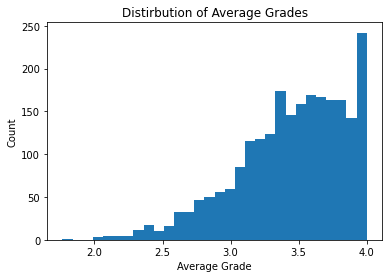

In [19]:
# Plot a histogram of the distribution of average grades
plt.hist(df.avg_grade, bins=30)
plt.title("Distirbution of Average Grades")
plt.xlabel("Average Grade")
plt.ylabel("Count")
plt.show()

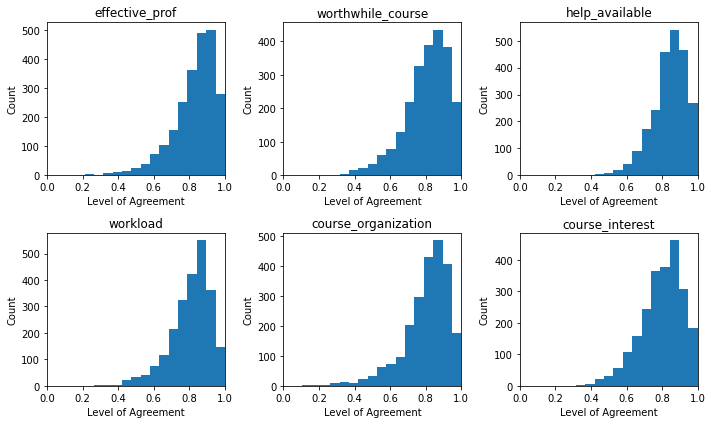

In [20]:
# Plot histograms for the responses to each SOCT question
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var in zip(axs.flat, Data.columns):
    ax.hist(df[var], bins=np.linspace(0,1,20))
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Count")
    ax.set_xlim(0,1)

plt.tight_layout()
plt.show()

# Relationship Between SOCT Responses and Average Grade

## Correlation Matrix

In preparation for forming a linear model, we create a correlation matrix. We notice that there are strong correlations around 0.7 and 0.8 between the SOCT survey responses. The correlations with average grade are significantly lower, closer to 0.4 or 0.5. This indicates that we may have issues performing multiple regression (due to the strong collinearity), but single regression should still perform correctly. Most importantly, this matrix indicates that all the correlations are positive, as expected.

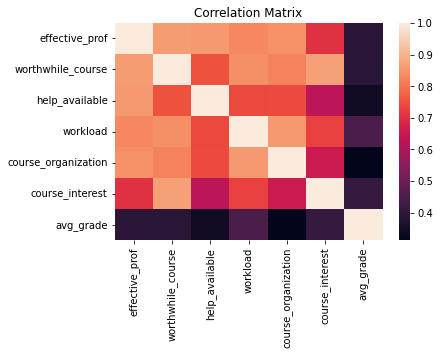

In [21]:
# Create a correlation matrix for the SOCT questions and average grade
sns.heatmap(df[Data.columns + ["avg_grade"]].corr())
plt.title("Correlation Matrix")
plt.show()

## Linear Models

We now fit linear models with each SOCT question as the predictor and the average grade as the response. Each of the models are quite poor at predicting average grade, with R-squared values between 0.1 and 0.2. Nevertheless, the correlation is certainly present, as indicated by p-values that are significantly lower than 0.05. Thus, we conclude that each SOCT response is positively correlated with average grade.

By analyzing the magnitude of the coefficient, we can identify which SOCT responses are most strongly related to average grade. The resonability of the workload has the highest coefficient of 1.57, followed by the availability of help with 1.40. Therefore, we expect that these two factors have the highest impact on the grade a student receives. However, before we can conclude this, we must check to make sure the conditions for regression were satisfied, which we do next.

In [22]:
# Fit linear models predicting average grade from each SOCT question, and store them in a dictionary
models = {var: smf.ols("avg_grade ~ "+var, df).fit() for var in Data.columns}

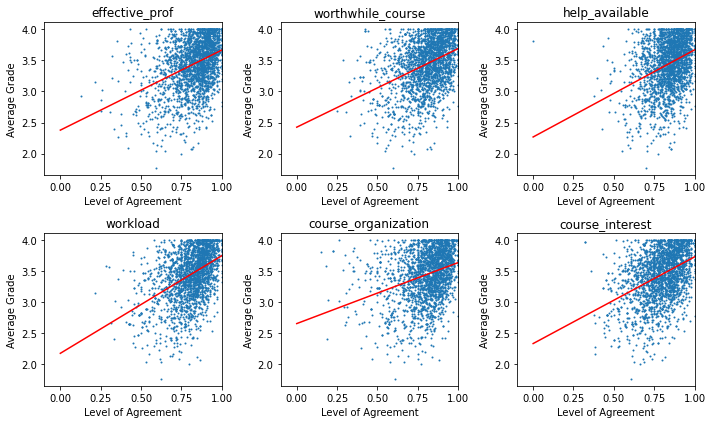

In [23]:
# Create scatter plots of each linear model
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model in zip(axs.flat, Data.columns, models.values()):
    ax.scatter(df[var], df.avg_grade, s=1)
    
    x = np.linspace(0,1,100)
    y = model.predict({var:x})
    ax.plot(x, y, "red")
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(-0.1,1)

plt.tight_layout()
plt.show()

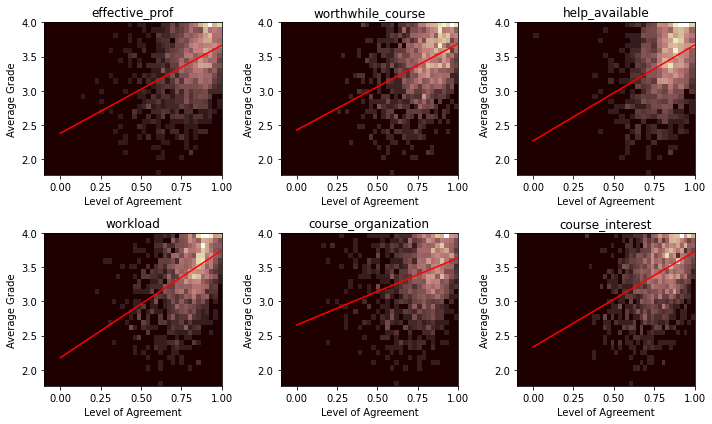

In [24]:
# Create 2D-Density plots of each linear model
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model in zip(axs.flat, Data.columns, models.values()):
    im = ax.hist2d(df[var], df.avg_grade, bins=30, cmap="pink")
    
    x = np.linspace(0,1,100)
    y = model.predict({var:x})
    ax.plot(x, y, "red")
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(-0.1,1)
    ax.set_facecolor((0.1178, 0, 0, 1))

plt.tight_layout()
plt.show()

In [25]:
# View the results of each model
results_list = []

for model in models.values():
    values = {"rsquared": model.rsquared,
              "intercept": model.params[0],
              "coeff": model.params[1],
              "coeff_pvalue": model.pvalues[1]
             }
        
    results_list.append(values)
    
pd.DataFrame(results_list, index=Data.columns)

rsquared  intercept     coeff   coeff_pvalue
effective_prof       0.153260   2.378232  1.287781   9.924464e-86
worthwhile_course    0.152282   2.425553  1.264573   3.787748e-85
help_available       0.119121   2.267982  1.401410   8.329608e-66
workload             0.200749   2.175761  1.570262  8.384617e-115
course_organization  0.097976   2.654085  0.981408   7.717241e-54
course_interest      0.169900   2.332620  1.394963   9.938801e-96

In [26]:
# View the diagnostic plots for each model
@interact(variable = Data.columns)
def inner(variable):
    print()
    allplots(models[variable], figsize=(10, 6))
    plt.show()

interactive(children=(Dropdown(description='variable', options=('effective_prof', 'worthwhile_course', 'help_a…

Before conclusions are drawn, it is necessary to ensure that the conditions for linear regression were met. This is done using the OLSplots package by Jason Sadowski, which provides diagnostic plots similar to those found in R. The plots (displayed above) all serve a purpose in evalating the conditions for linear regression:

### Residuals vs. Fitted Plot


This plot helps to indicate whether the relationship is linear. There should be no relationship of the residuals with respect to the fitted values, which should manifest itself as a horizontal red line. For all the variables except course interest, there appears to be some increase in the residuals for lower fitted values. For effective professor, worthwhile course, and workload, this is miniscule enough to be insignificant. For course organization, it is more significant. This is concerning, since this may be the cause of the very low coefficient for this variable. By fitting a similar model excluding low levels of agreement (specifically only fitting it to datapoints whose level of agreement is greater than 50%), we obtain a model that does not have this issue, and yet the coefficient is still only 1.28, and so our conclusion that course organization is less significant than workload and help available still holds.

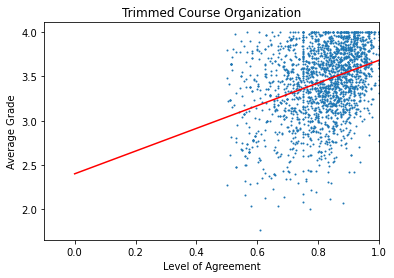

In [27]:
temp_df = df[df.course_organization>0.5]

temp_model = smf.ols("avg_grade ~ course_organization", temp_df).fit()

plt.scatter(temp_df.course_organization, temp_df.avg_grade, s=1)

x = np.linspace(0,1,100)
y = temp_model.predict({"course_organization":x})
plt.plot(x, y, "red")

plt.title("Trimmed Course Organization")
plt.xlabel("Level of Agreement")
plt.ylabel("Average Grade")
plt.xlim(-0.1,1)

plt.show()

In [28]:
temp_model.params

Intercept              2.399189
course_organization    1.284071
dtype: float64

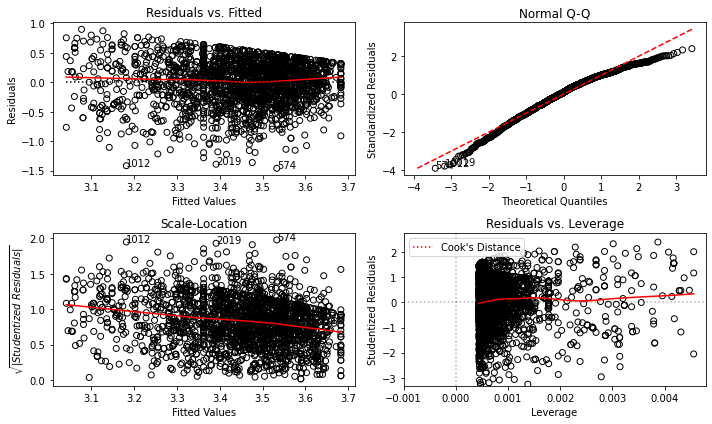

In [29]:
allplots(temp_model, figsize=(10, 6))
plt.show()

Lastly, we notice that there is an outlier for help available given at index 2152. The course is SW 441, and it has a high average grade but a survey response of 0 for help availablility. This datapoint is therefore pulling the left side of the regression line up, resulting in a lower slope. Fitting the model without this outlier results in a change of slope from 1.40 to 1.46. While this is significant, it does not change our conclusion (this is still less significant than workload). 

In [30]:
df.iloc[2152]

index                         6010
subject                         SW
subject_desc           Social Work
course                         441
effective_prof                0.35
worthwhile_course              0.6
help_available                 0.0
workload                      0.45
course_organization           0.15
course_interest                0.7
avg_grade                 3.807692
Name: 2152, dtype: object

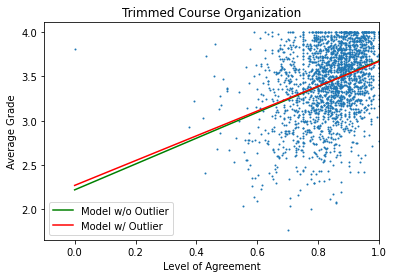

In [31]:
temp_df = df.drop(2152)

temp_model = smf.ols("avg_grade ~ help_available", temp_df).fit()

plt.scatter(df.help_available, df.avg_grade, s=1)

x = np.linspace(0,1,100)
y = temp_model.predict({"help_available":x})
plt.plot(x, y, "green", label="Model w/o Outlier")

y = models["help_available"].predict({"help_available":x})
plt.plot(x, y, "red", label="Model w/ Outlier")

plt.title("Trimmed Course Organization")
plt.xlabel("Level of Agreement")
plt.ylabel("Average Grade")
plt.xlim(-0.1,1)

plt.legend()
plt.show()

In [32]:
models["help_available"].params

Intercept         2.267982
help_available    1.401410
dtype: float64

In [33]:
temp_model.params

Intercept         2.217610
help_available    1.460594
dtype: float64

### Normal Q-Q Plot

This plot indicates whether the residuals are normally distributed. Ideally, the points should fall along a straight line. For all of the variables, the points tend to lie below the line. This indicates that the residuals are skewed to the left. This is also noticable from the scatter plots (the points trail down futher below the model than they trail above). We note that this may result in somewhat inaccurate p-values, and continue our analysis. We also note that it may help to transform the data (since the original distributions are so skewed, this is resulting in the residuals being skewed).

### Scale-Location Plot

This plot indicates whether homoscedasticity is satisfied. Specifically, the variance of the residuals should be equal for all fitted values (there shouldn't be an increase or decrease in the variance of the residuals). Again, this condition is not entirely satisfied. The variance appears to be higher for lower fitted values. This is especially prevalent for help available, but this is mainly due to the outlier (which we analyzed above). Again, we might consider transforming the data to solve this issue.

### Residuals vs. Leverage Plot

This plot identifies points of high leverage (outliers that significantly impact the model). The main concern is whether any points lie outside of a Cook's distance of 0.5, but none do for any of the models. However, we do note that the outlier in help available certainly has a high leverage, and thus it may be reasonable to consider a model without it as we did above.

## Transformed Data

Source for Box-Cox Transformation: https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation

As found above, our models would be more justified if we could transform the data to be more normally-distributed. One such transformation is the Box-Cox transformation, which is intended to transform skewed data into normally-distributed data. The transformation is the following, where $x$ is the original value, $y$ is the transformed value, and $\lambda$ is a parameter:

$$y=\left\{\begin{matrix}\frac{x^\lambda-1}\lambda&\text{if }\lambda\neq0\\\ln x&\text{if }\lambda=0\end{matrix}\right\}$$

The function `boxcox` tunes the value of $\lambda$ so that it "maximizes the log-likelihood function." In other words, we do not need to worry about the value of $\lambda$, as long as the transformation appears to be working (and we can see it is performing fairly well by the below histograms). Of course, due to the large number of grades that were exactly 4.0, the Box-Cox transform is unable to transform this part to a normal distribution; nevertheless, the distribution is an improvement over the previous one.

To understand why this transformation works, we plot the Box-Cox function for average grade. As the average grade increases, the derivative of the function also increases, indicating that the transformed values will become more spaced out. This thereby reduces the skew in the data.

In [34]:
# Create a dataframe where each column undergoes the boxcox transform
df_mod = pd.DataFrame()
df_mod["avg_grade"], lmbd_y = boxcox(df.avg_grade) # Store the optimal value of lambda found for average grade

lmbds = [None]*6 # Create a list for storing the optimal values of lambda for each SOCT question
for i, var in enumerate(Data.columns):
    df_mod[var], lmbds[i] = boxcox(df[var]+1) # Store the optimal value of lambda found for each SOCT question

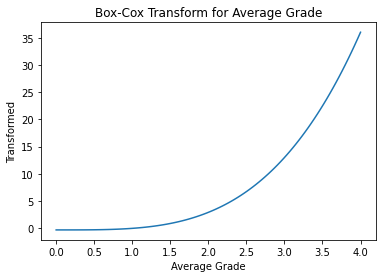

In [35]:
x = np.linspace(0.001,4,100)
y = boxcox(x, lmbda=lmbd_y)
plt.plot(x, y)
plt.title("Box-Cox Transform for Average Grade")
plt.xlabel("Average Grade")
plt.ylabel("Transformed")
plt.show()

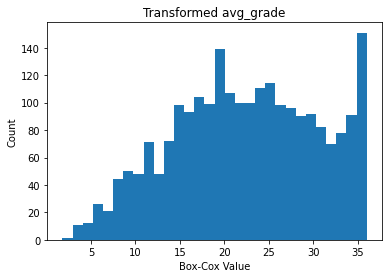

In [36]:
# Plot the average grades under a boxcox transform
plt.hist(df_mod.avg_grade, bins=30)
plt.title("Transformed avg_grade")
plt.xlabel("Box-Cox Value")
plt.ylabel("Count")
plt.show()

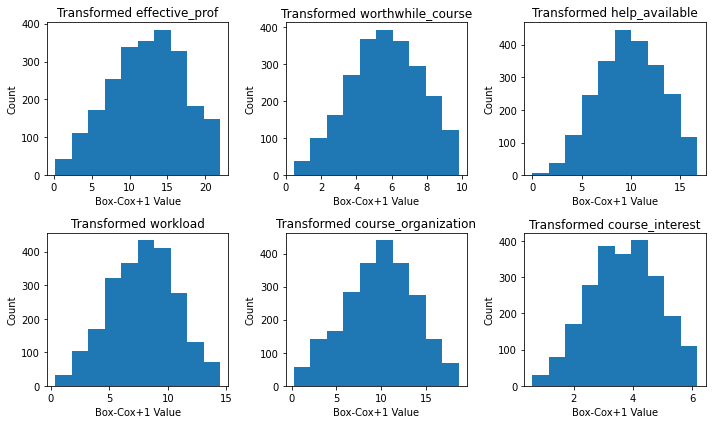

In [37]:
# Plot histograms for the responses to each SOCT question under a boxcox transform
fig, axs = plt.subplots(2, 3, figsize=(10,6))
    
for ax, var in zip(axs.flat, Data.columns):
    ax.hist(df_mod[var]) # Add one to the data to ensure that it is strictly positive
    ax.set_title("Transformed "+var)
    ax.set_xlabel("Box-Cox+1 Value")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

We now fit models using the transformmed data. To plot the result, we then call `inv_boxcox`, which performs the inverse of the transform. We notice that our models are now concave up, and tend to approach a flat line for low levels of agreement. This is not the most intuitive model, nor are the coefficients comparable (since different values of lambda were used for each). Therefore, the linear models may be better suited for analysis. Nevertheless, we notice that the conditions for linear regression are now satisfied better. The lines for Residuals vs. Fitted and Scale-Location are both horizontal. The only remaining issue is that the distribution of residuals have light tails (a condition called platykurtosis). This is indicated by the tails of the Q-Q plot twising clockwise.

In [38]:
# Fit linear models predicting transformed average grade from each transformed SOCT question, and store 
# them in a dictionary
mod_models = {var: smf.ols("avg_grade ~ "+var, df_mod).fit() for var in Data.columns}

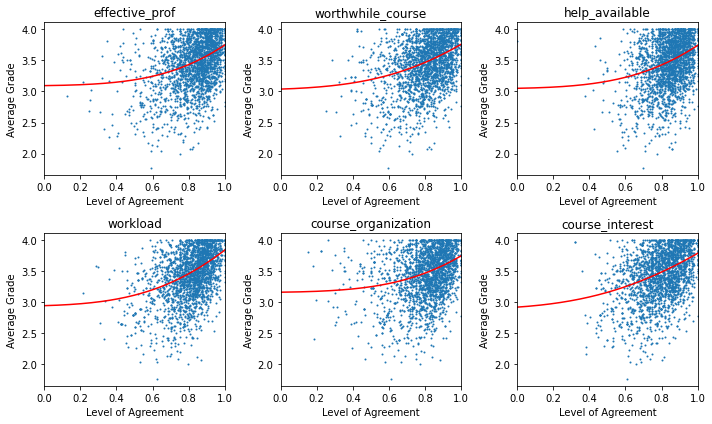

In [39]:
# Create scatter plots of each model
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model, lmbd in zip(axs.flat, Data.columns, mod_models.values(), lmbds):
    ax.scatter(df[var], df.avg_grade, s=1)
    ylims = ax.get_ylim()
    
    x = np.linspace(-100,100,int(1e4))
    y = model.predict({var:x})
    ax.plot(inv_boxcox(x, lmbd)-1, inv_boxcox(y,lmbd_y), "red") # Perform the inverse transformations
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(0,1)
    ax.set_ylim(*ylims)

plt.tight_layout()
plt.show()

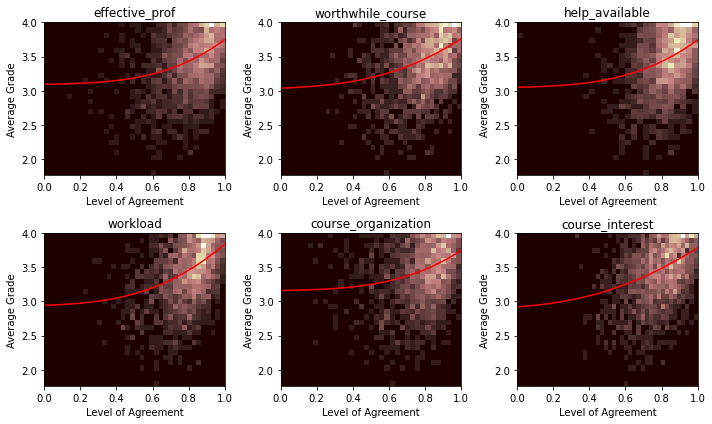

In [40]:
# Create 2D-Density plots of each model
fig, axs = plt.subplots(2, 3, figsize=(10,6))
for ax, var, model, lmbd in zip(axs.flat, Data.columns, mod_models.values(), lmbds):
    im = ax.hist2d(df[var], df.avg_grade, bins=30, cmap="pink", vmin=0)
    
    x = np.linspace(-100,100,int(1e4))
    y = model.predict({var:x})
    ax.plot(inv_boxcox(x, lmbd)-1, inv_boxcox(y,lmbd_y), "red") # Perform the inverse transformations
    
    ax.set_title(var)
    ax.set_xlabel("Level of Agreement")
    ax.set_ylabel("Average Grade")
    ax.set_xlim(0,1)
    ax.set_facecolor((0.1178, 0, 0, 1))

plt.tight_layout()
plt.show()

In [41]:
# View the results of each model
results_list = []

for model in mod_models.values():
    values = {"rsquared": model.rsquared,
              "intercept": model.params[0],
              "coeff": model.params[1],
              "coeff_pvalue": model.pvalues[1]
             }
        
    results_list.append(values)
    
pd.DataFrame(results_list, index=Data.columns)

rsquared  intercept     coeff   coeff_pvalue
effective_prof       0.147227  14.512179  0.643866   3.750860e-82
worthwhile_course    0.150616  13.601726  1.565822   3.693145e-84
help_available       0.118733  13.802215  0.874464   1.389881e-65
workload             0.206946  12.125621  1.311800  1.008399e-118
course_organization  0.110987  15.621838  0.692859   3.603519e-61
course_interest      0.170552  11.778897  2.894393   3.992141e-96

In [42]:
# View the diagnostic plots for each model
@interact(variable = Data.columns)
def inner(variable):
    print()
    allplots(mod_models[variable], figsize=(10, 6))
    plt.show()

interactive(children=(Dropdown(description='variable', options=('effective_prof', 'worthwhile_course', 'help_a…

## Multivariable Model

Source for Variance Inflation Factor: https://towardsdatascience.com/everything-you-need-to-know-about-multicollinearity-2f21f082d6dc

Lastly, we fit a multivariable model using all of the SOCT responses as predictors. As noticed by the below output, the coefficients differ greatly from each other, ranging from -1.03 to 1.81. This is likely not indicatory of the actual relationships present; rather, it is likely a byproduct of the fact that the predictors are strongly correlated (refer back to the correlation matrix). Due to this multicollinearity, the model is able to use the different coefficients to fit noise in the dataset, rather than the actual relationships present.

The collinearity of the SOCT responses can be confirmed numerically through the variance inflation factor (VIF). For any predictor, this value is equal to $\frac1{1-R^2}$, where $R^2$ is the coefficient of determination for a model with that predictor as the dependent variable and all other predictors as the independent variables. A low VIF is desirable, and in our case, we would expect a VIF of below 10 to ensure that the predictors are independent. From the output below, this is clearly not the case, so we abandon our multivariable model.

In [43]:
# Fit a multiple regression model using all SOCT questions as predictors
formula = "avg_grade ~ "+" + ".join(Data.columns)
multi_model = smf.ols(formula, df).fit()
multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_grade   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     127.3
Date:                Mon, 06 Dec 2021   Prob (F-statistic):          2.19e-139
Time:                        11:51:06   Log-Likelihood:                -837.28
No. Observations:                2317   AIC:                             1689.
Df Residuals:                    2310   BIC:                             1729.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0139      0.066     30.506      0.000       1.884       2.143
effective_prof          0.7405      0.161      4.586      0.000       0.424       1.057
worthwhile_course      -0.6073      0.180     -3.377      0.001      -0.960      -0.255
help_available         -0.0429      0.143     -0.301      0.764      -0.323       0.237
workload                1.8101      0.142     12.784      0.000       1.532       2.088
course_organization    -1.0325      0.127     -8.116      0.000      -1.282      -0.783
course_interest         0.8931      0.128      6.991      0.000       0.643       1.144
==============================================================================
Omnibus:                      137.475   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.473
Skew:                          -0.624   Prob(JB):                     8.64e-36
Kurtosis:                       3.342   Cond. No.                         68.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Display the variance inflation factors for each predictor
display(pd.DataFrame([variance_inflation_factor(df[Data.columns], i) for i in range(6)], columns=["Variance Inflation Factors"], index=Data.columns))

print(f"The value should be less than {max(10, 1/(1-model.rsquared_adj))} to be considered uncorrelated.")

Variance Inflation Factors
effective_prof                       342.384590
worthwhile_course                    402.205559
help_available                       200.062404
workload                             248.708956
course_organization                  206.087782
course_interest                      191.432018

The value should be less than 10 to be considered uncorrelated.


# Subject Comparisons

Source for Popular MSU Majors: https://www.usnews.com/best-colleges/michigan-state-2290/academics

We now move on to our next question, which is how the SOCT survey responses vary between subjects, and whether certain subjects recieve more favorable responses. For reference (and identifying possible subjects to analyze), we plot a histogram of all subjects with more than 10 observations. Based on the above source, we decide to analyze business-, finance-, biology-, and communication-related subjects. We also analyze subjects in math or applied math, since this is of personal interest to me.

Below are boxplots comparing different subjects within each category. Under the business category, we see that the actual business classes tend to be ranked the best, perhaps with the exception of worthwhile course (it is on par with management and supply chain management, but all of these are significantly lower than entrepreneurship). Under the finance category, the finance and insurance classes tend to be ranked the best (except in course organization), while economics is ranked the worst. In the biology category, biological science tends to be ranked worse than biochem and molecular biology, which in turn is ranked worse than biosystems engineering (except in the case of course organization). For the communication category, they all tend to be on par with each other, perhaps with journalism exceeding the other in a few cases. Lastly, for the applied math category, we see that mathematics and statistics tend to be approximately the same. CMSE lacks in workload and organization, but surpasses them in course interest and worthwhile course.

Of course, more interesting is comparing these categories to each other (rather than doing within-group comparisons). This is done through both boxplots (using the median allows a quick comparison) and ridgeplots (which provide more detailed views of the distributions). The results we find are as follows:

* For effective professor, business and communication are both ranked well (and approximately the same), whereas biology, finance, and math are ranked worse and the same. On the ridgeplots, this is noticable by the peaks of business and communication being further to the right. The other three subjects also have stronger skews to the left.
* For worthwhile course, business and communication again are ranked the best, followed by finance and math, then biology. The distribution for biology is particularly skewed to the left, almost being bimodal.
* For help available, all have nearly the same values. Business, communication, and math all are about the same, followed slightly behind by biology and finance. The ridgeplot helps to emphasize that biology is ranked slightly less than the others (particularly business).
* For workload, the same trend as worthwhile course is seen. However, we also see that the distribution for biology is extremely spread out, again forming two peaks.
* For course organization, communication is ranked the best, followed by business, finance, and math. Biology is again ranked the worst, and again forms a spread out bimodal distribution.
* For course interest, business and communication are ranked the best, followed by biology and finance. Mathematics is ranked the lowest (the distribution is extremely spread out with a peak further to the left).

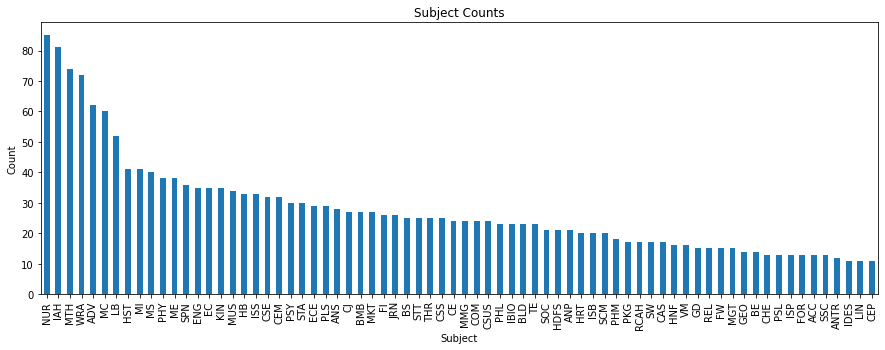

In [45]:
# Count the number of courses under each subject
subject_counts = df.subject.value_counts()

# Plot a histogram of subjects whose counts are above 10
plt.figure(figsize=(15,5))
subject_counts[subject_counts>10].plot.bar()
plt.title("Subject Counts")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.show()

In [46]:
# Sources: https://stackoverflow.com/a/44713292

# Create a list of groups of subjects to analyze
subjects_list = [["BUS", "MGT", "SCM", "ESHP"],
            ["EC", "ACC", "FI"],
            ["BS", "BMB", "BE"],
            ["COM", "JRN", "ADV", "MKT"],
            ["MTH", "STT", "CMSE"]]

# Specify the category under which these subjects fall
names = ["Business", "Finance", "Biology", "Communication", "Math/Applied Math"]

# Specify order of boxplots
order = ["effective_prof", "worthwhile_course", "help_available", "workload", "course_organization", "course_interest"]

def get_long_data(name):
    '''Given a category from above, return a DataFrame containing the SOCT data for courses in that category
    which is in long format (instead of each SOCT question being a column, a column for variables and a column
    for values are used).
    
    Parameters
    ----------
    name: str
        The name of the category. Must be present in names.
        
    Returns
    -------
    long_data: DataFrame
        The data in long format.
    '''
    
    index = names.index(name) # Find the index of the name in names
    subjects = subjects_list[index] # Get the corresponding subjects
    
    # Filter df for the appropriate subjects and convert it to long format
    long_data = df[df.subject.isin(subjects)].melt(id_vars=["subject_desc"], value_vars=Data.columns)
    # Add a column containing the name (for use later... many of these outputs will be merged together, and this
    # column will allow them to be grouped
    long_data["category"] = name 
    return long_data
    
# Display boxplots for the subjects in the given category
@interact(category = names)
def plot_subjects(category):
    long_data = get_long_data(category)
    plt.figure(figsize=(10,6))
    sns.boxplot(x="variable", y="value", hue="subject_desc", data=long_data, order=order)
    plt.xticks(rotation="45", rotation_mode="anchor", ha="right")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Variable")
    plt.ylabel("Rating")
    plt.title(category+"-Related Subjects")
    plt.show()

interactive(children=(Dropdown(description='category', options=('Business', 'Finance', 'Biology', 'Communicati…

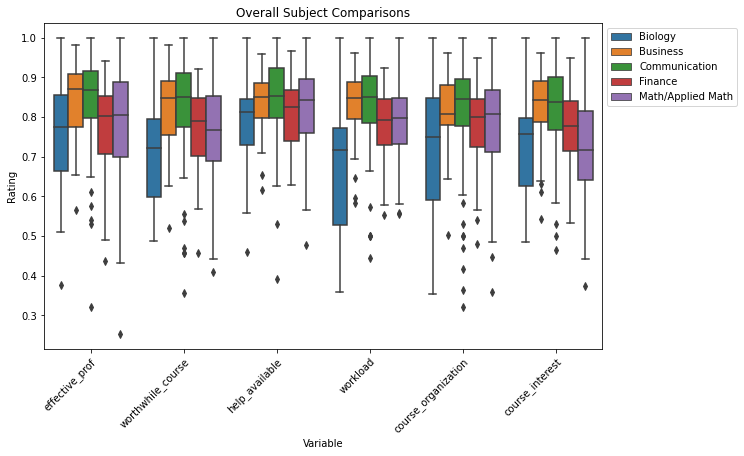

In [47]:
# Get long data for each category and merge them together
long_data = pd.concat([get_long_data(name) for name in names]).sort_values("category")

# Display a boxplot for each SOCT question, colored by category
plt.figure(figsize=(10,6))
sns.boxplot(x="variable", y="value", hue="category", data=long_data, order=order)
plt.xticks(rotation="45", rotation_mode="anchor", ha="right")
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Variable")
plt.ylabel("Rating")
plt.title("Overall Subject Comparisons")

plt.show()

In [48]:
# Sources: https://stackoverflow.com/a/60215826

# Convert the long data back to wide. This is done so that the category column is retained (rather than using the 
# original data)
wide_data = long_data.copy() # Create a copy of long_data to be modified
# Add a column using cumulative counting within each group to ensure that the dataframe can be pivoted wider.
# Without doing this, there would be duplicate indices, which would throw an error
wide_data["cumcount"] = wide_data.groupby(["subject_desc", "category", "variable"]).cumcount()
# Pivot the data so that it is in wide format, using the subject description, category, and cumcount as the index.
# Then reset the index
wide_data = wide_data.pivot(columns=["variable"], index=["subject_desc", "category", "cumcount"]).reset_index()
# Reduce the MultiIndex column names to regular column names. This is done by replacing "value" with an empty string,
# so that for every column, only one value in the MultiIndex is a non-empty string. Then, the level values of the 
# MultiIndex can be added to obtain a list of strings.
wide_data.rename(columns={"value": ""}, inplace=True)
wide_data.columns = wide_data.columns.get_level_values(0)+wide_data.columns.get_level_values(1)
wide_data.drop("cumcount", axis=1, inplace=True) # Remove cumcount

In [49]:
# Sources: https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052

# Display ridge plots for each SOCT question by category
@interact(variable = Data.columns)
def plot_subjects(variable):
    fig, axs = joyplot(
        data=wide_data, 
        by = "category",
        column=variable,
        figsize=(12, 8),
        overlap=2.5,
        fill=True,
        color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:5] # Use Matplotlib default colors
    )
    
    # Change the xticks and xlim for all ridges
    for ax in axs:
        ax.set_xlim(0.2,1)
        ax.set_xticks(np.arange(.2,1.1,0.1))

    plt.title("Distributions of "+variable)
    plt.xlabel("Value")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('effective_prof', 'worthwhile_course', 'help_a…

# Course Number Comparisons

To answer our last question, we add a column to the dataframe representing the level of the course (either 100, 200, 300, or 400). We see that the average grades do not vary significantly by course level. If anything, there is a slight increase in average grade from 200 level to 300 level and then to 400 level, although this is quite small.

For the SOCT responses, there are slight variations in the distributions, but it is unclear whether these represent an actual trend or just error. The one significant trend that we notice is an increase in course interest as the course level increases (both represented by shifts in the center and reductions in leftward skew as course level increases). This agrees with our expectations, since higher level courses tend to be more specific to a student's major.

In [50]:
# Add a column to df representing the course level (either 100, 200, 300, or 400)
df["level"] = df.course.apply(lambda x: x[0]+"00")
# Count the number of occurences of each course level
level_counts = df.level.value_counts().reindex(["100", "200", "300", "400"])

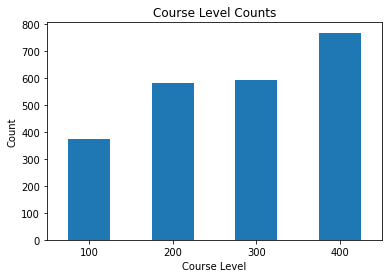

In [51]:
# Plot the number of occurences of each course level as a bar chart
level_counts.plot.bar(rot=0)
plt.xlabel("Course Level")
plt.ylabel("Count")
plt.title("Course Level Counts")
plt.show()

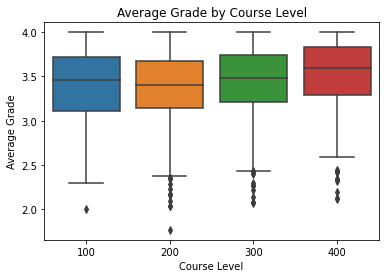

In [52]:
# Create boxplots of the average grade for each course level
sns.boxplot(x="level", y="avg_grade", data=df, order=level_counts.index)
plt.xlabel("Course Level")
plt.ylabel("Average Grade")
plt.title("Average Grade by Course Level")
plt.show()

In [53]:
# Create ridge plots of the SOCT questions for each course level

@interact(variable = Data.columns)
def plot_levels(variable):
    fig, axs = joyplot(
        data=df, 
        by = "level",
        column=variable,
        figsize=(12, 8),
        overlap=2.5,
        fill=True,
        color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:5] # Use Matplotlib default colors
    )
    
    # Change the xticks and xlim for all ridges
    for ax in axs:
        ax.set_xlim(0.2,1)
        ax.set_xticks(np.arange(.2,1.1,0.1))

    plt.title("Distributions of "+variable)
    plt.xlabel("Value")
    plt.ylabel("Subject")
    plt.show()

interactive(children=(Dropdown(description='variable', options=('effective_prof', 'worthwhile_course', 'help_a…

# Summary

## Models Used

To answer the first question, we use regression as our model. We attempt three different forms:
1. We perform ordinary least squares regression with an SOCT question as the predictor and the average grade as a response. This type of model finds a straight line such that the sum of the squared residuals (or errors) is minimized. We use the p-value to determine if there is a statistically significant relationship, and we use the magnitude of the coefficient to determine the practical significance of this predictor.
2. To better satisfy the conditions for linear regression, we transform both the average grade and SOCT responses using the Box-Cox transform. As discussed above, this function helps to transform skewed data such that it better resembles a normal distribution. The resulting model is concave up. Due to the varying parameters used by the transform, this makes it hard to make comparisons, but it does again show that all the relationships are statistically significant.
3. Finally, we attempt a multivariable model. In this case, multiple predictors are combined through a linear combination, where the coefficients are determined so that the sum of the squared residuals is again minimized. However, due to the strong collinearity of the SOCT responses, the result is not accurate (it reflects the noise in the dataset rather than the actual trends present).

To answer the next two questions, we use visual models:
1. Boxplots are used for quick comparisons. Boxplots show the medians by a line and the interquartile ranges by a box. This allows the values to be compared both in terms of center and spread.
2. Ridgeplots are used to more closely examine the distributions themselves. This makes comparisons more difficult, but it can reveal additional information about how many peaks there are and how the skew is shaped.

## Computational Techniques

We use the following techniques:
* Selenium is used for performing the webscraping of the SOCT website.
* Pandas is used to transform and merge the two datasets.
* Matplotlib, Seaborn, and JoyPy are used to visualize the results (with scatter/density plots, boxplots, and ridgeplots respectively).
* Statsmodels is used to perform regression and analyze the coefficients/p-values.
* Scipy is used to perform the Box-Cox transformation on the data.
* OLSplots is used to analyze whether the conditions for linear regression are met.

## Answers

For the first question, we determine that all of the SOCT responses have a statistically significant positive correlation with average grade. However, the reasonability of the workload has the most impact, followed by the availability of help. The model predicts that a course where the students responded with 100% agreement to the workload being reasonable has an average grade that is on average 1.57 higher than a course where the students responded with 0%. Similarly, the model predicts that a course where the students responded with 100% agreement to the professor being available to help has an average grade that is on average 1.40 higher than a course where the students responded with 0%.

For the second question, we found that business and communication classes tend to be ranked better than applied math and finance, which in turn are ranked better than biology. However, applied mathematics is ranked the lowest for course interest. Additionally, biology tends to have responses following a bimodal distribution. Attempting to predict the cause of this could be a question for future research.

For the third question, we see a slight increase in average grade as course level increases, as well as an increase in course interest. The other SOCT variables do not show a significant change.

## Difficulties

The first major difficult was obtaining usable data. The SOCT responses were only available through a website search, so to obtain all the data, a webscraper had to be coded and run (which was quite time consuming). More difficult, however, was merging this dataset with the msugrades data. The professors were encoded very differently, so in order to merge them, a more complicated process had to be conducted. Specifically, the rows were merged on the basis of subject and course, and then the similarity of the two names were ranked (upon which the rows with the highest similarity was kept).

During data analysis, the major difficulty was ensuring that conditions for regression were met. For help available, there was a significant outlier impacting the model. To account for this, we also fit a model that did not include it, and obtained the same results (namely, that it is the second most significant predictor). For course organization, curvature was noticable in the residual plot, indicating that the relationship may not be linear. To ensure that our conclusion was still correct, we fit a localized model only to the points where the level of agreement was greater than 50%, and we obtained a larger slope (but one that was still less than that of workload and help available). There was also non-normality of the residuals and heteroscedasticity, which we were able to account for by performing a Box-Cox transformation.